# Fatest path data generator

given generate num, grid size, car number(total_trajectories)
generate random OD
get capacity (weighted graph)
generate fasted route according to OD and capacity

## 1. Generate trajectories for training

In [1]:
import networkx as nx

# random simulation time
simulation_num = 0
# Define the grid size
grid_size = 5
# Define the total number of trajectories
total_trajectories = 1
capacity_scale = 10
weight_quantization_scale = None # quantization scale for the weights, and in the network turn into embedding, None means no quantization

import numpy as np
import matplotlib.pyplot as plt
import copy

def get_capacity(capacity_scale = 10, grid_size = 10):
    grid_capacity = np.random.uniform(1,capacity_scale,grid_size*grid_size)
    return grid_capacity

def get_adjacency(grid_size=10):
    adj = np.zeros([grid_size*grid_size,grid_size*grid_size],dtype= int)
    for i in range(grid_size):
        for j in range(grid_size):
            if i>0:
                adj[(i-1)*grid_size+j,i*grid_size+j] = 1
            if i<grid_size-1:
                adj[(i+1)*grid_size+j,i*grid_size+j] = 1
            if j>0:
                adj[i*grid_size+j-1,i*grid_size+j] = 1
            if j<grid_size-1:
                adj[i*grid_size+j+1,i*grid_size+j] = 1
    return adj

def get_length():
    return np.ones(grid_size*grid_size,dtype= int)

def get_weighted_adjacency(adj, grid_capacity, length, normalization = True, quantization_scale = None):
    weighted_adj = copy.deepcopy(adj)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i,j] == 1:
                weighted_adj[i,j] = (grid_capacity[j]+1)*length[j]
    if normalization:
        weighted_adj = weighted_adj/np.max(weighted_adj)
    if quantization_scale:
        weighted_adj = np.ceil(weighted_adj*quantization_scale)
        
    return weighted_adj

# transfer node, wrighted_adj to graph
def transfer_graph(weighted_adj, grid_size):
    G = nx.DiGraph()
    for i in range(grid_size*grid_size):
        G.add_node(i)
    for i in range(grid_size*grid_size):
        for j in range(grid_size*grid_size):
            if weighted_adj[i,j] != 0:
                G.add_edge(i,j,weight=weighted_adj[i,j])
    return G


# get shortest traj
def generate_trajectory_list(OD_list, weighted_adj):
    trajectory_list = []
    G = transfer_graph(weighted_adj, grid_size)
    for i in range(len(OD_list)):
        trajectory = nx.shortest_path(G, (OD_list[i][0][0]-1)*grid_size+OD_list[i][0][1]-1, (OD_list[i][1][0]-1)*grid_size+OD_list[i][1][1]-1, weight='weight')
        for j in range(len(trajectory)):
            trajectory[j] = (trajectory[j]//grid_size+1,trajectory[j]%grid_size+1)
        trajectory_list.append(trajectory)
    return trajectory_list
        

def get_OD_list(grid_size=10, trajectory_num = 10):
    # define OD [trajectory_num,2,2] (N*[[x_start,y_start],[x_end,y_end]])
    # 1-indexing
    OD_list = np.random.randint(1,grid_size+1,[trajectory_num,2,2])
    return OD_list


# Generate the codebook
codebook = {}
max_value = grid_size  # max(y) = 10 in this case

# Populate the codebook with grid cells
for x in range(1, grid_size + 1):
    for y in range(1, grid_size + 1):
        code = (x - 1) * max_value + y
        codebook[(x, y)] = str(code)
codebook[(0,0)] = f'{grid_size*grid_size+1}'
codebook[(grid_size+1,grid_size+1)] = f'{grid_size*grid_size+2}'

# Save the codebook to a file
with open('./data/codebook.txt', 'w') as file:
    for key, value in codebook.items():
        file.write(f'{key}: {value}\n')


In [2]:

#simulation for simulation_num times
if simulation_num != 0:
    for t in range(simulation_num):
        # print(f'simulation {t}')
        # Generate and save 10 trajectories
        all_encoded_trajectories = []
        all_weighted_adj = []

        OD_list = get_OD_list(grid_size=grid_size, trajectory_num= total_trajectories)
        # grid_capacity = get_capacity(current_trajectory_list=OD_list[:,0,:],grid_size=grid_size)
        grid_capacity = get_capacity(capacity_scale,grid_size)
        adj = get_adjacency(grid_size=grid_size)
        road_len = get_length()
        weighted_adj = get_weighted_adjacency(adj=adj,grid_capacity=grid_capacity,length=road_len, normalization=True, quantization_scale=weight_quantization_scale)
        trajectory_list = generate_trajectory_list(OD_list, weighted_adj)

        for i in range(total_trajectories):
            trajectory = trajectory_list[i]
            encoded_trajectory = [codebook[(x, y)] for x, y in trajectory]
            # # Append '0' at the end of each trajectory
            # encoded_trajectory.append('0')
            all_encoded_trajectories.append(encoded_trajectory)
            all_weighted_adj.append(weighted_adj)


        # Save all trajectories to a single file
        with open(f'./data/trajectory_{t}.txt', 'w') as file:
            # file.write(' '.join(all_encoded_trajectories))
            for trajectory in all_encoded_trajectories:
                file.write(' '.join(trajectory))
                file.write('\n')
        np.save(f'./data/weighted_adjacency_{t}.npy', weighted_adj)
        print(f'simulation {t} saved')

    # # print trajectory
    # for i in range(total_trajectories):
    #     print(f'trajectory {i+1}')
    #     print(trajectory_list[i])

    # Plotting the trajectory
    for i in range(total_trajectories):
        trajectory = []
        for j in range(len(trajectory_list[i])):
            x, y = trajectory_list[i][j]
            if x == 0 and y == 0:
                continue
            elif x == grid_size + 1 and y == grid_size + 1:
                break
            trajectory.append((x, y))
        trajectory_x, trajectory_y = zip(*trajectory)
        plt.plot(trajectory_x, trajectory_y, marker='o', label=f'Trajectory {i+1}')

    # Plot configuration
    plt.xlim(0, grid_size + 1)
    plt.ylim(0, grid_size + 1)
    plt.xticks(np.arange(1, grid_size + 1, 1))
    plt.yticks(np.arange(1, grid_size + 1, 1))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'total {len(trajectory_list[-1])} steps')
    plt.show()


## 2. Models

In [3]:
# Part 1. Define Functions
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from typing import Optional


# the X should be (B, N, L, C), B is batch size, N is the number of car, L is the max trajectory length, C is the embedding channel
# adj should be (V,V)

class NormalizedEmbedding(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.n_embd = n_embd

    def forward(self, x):
        x = self.embedding(x)
        return x/torch.norm(x, dim=-1, keepdim=True)


def get_1d_sincos_geo_embed(d_cross, pos):
    """
    d_cross: output dimension for each position
    pos: a list of positions to be encoded: size (V,)
    out: (M, D)
    """
    assert d_cross % 2 == 0
    omega = np.arange(d_cross // 2, dtype=np.float64)
    omega /= d_cross / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (V,)
    out = np.einsum('v,d->vd', pos, omega)  # (V, D/2), outer product

    emb_sin = np.sin(out)  # (V, D/2)
    emb_cos = np.cos(out)  # (V, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=-1)  # (V, D)
    return emb


def get_2d_sincos_geo_embed(emb_1d):
    """
    1d_emb: (V, D)
    out: (V, V, D)
    """
    emb_1d = emb_1d.reshape(-1, emb_1d.shape[-1])  # (V, D)
    emb_2d = np.einsum('hd,wd->hwd', emb_1d, emb_1d)  # (V, V, D)
    # print(emb_2d)
    return emb_2d


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, block_size, n_embd, dropout=0.1, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=in_proj_bias)
        self.query = nn.Linear(n_embd, head_size, bias=in_proj_bias)
        self.value = nn.Linear(n_embd, head_size, bias=in_proj_bias)
        self.out_proj = nn.Linear(head_size, head_size, bias=out_proj_bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        input_shape = x.shape
        batch_size, trajectory_num, sequence_length, head_size = input_shape

        # (batch_size, trajectory_num, sequence_length, head_size)
        k = self.key(x)
        # (batch_size, trajectory_num, sequence_length, head_size)
        q = self.query(x)
        # (batch_size, trajectory_num, sequence_length, head_size)
        v = self.value(x)

        # (B*N, T, T)
        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(head_size)
        weight = torch.masked_fill(weight, mask, value=-1e7)
        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)

        output = weight @ v
        output = self.out_proj(output)

        return output


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, block_size, dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, block_size, n_embd, dropout=dropout
                                         ) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 2 * n_embd),
            nn.SiLU(),
            nn.Linear(2 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(
            n_head, head_size, n_embd, block_size, dropout=dropout)
        self.ffwd = FeedFoward(n_embd, dropout=dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class CrossAttention(nn.Module):

    def __init__(self, n_heads: int, n_hidden: int, n_embd: int, dropout=0.1, in_proj_bias=True, out_proj_bias=True):
        super().__init__()

        self.q_proj = nn.Linear(n_hidden, n_hidden, bias=in_proj_bias)
        self.k_proj = nn.Linear(n_embd, n_hidden, bias=in_proj_bias)
        self.v_proj = nn.Linear(n_embd, n_hidden, bias=in_proj_bias)

        self.out_proj = nn.Linear(n_hidden, n_hidden, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = n_hidden // n_heads
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, adj: torch.Tensor):
        # x: (Traj) (B, N, L, H)
        # adj: (Road) (B, V, V, C)

        input_shape = x.shape
        batch_size, trajectory_num, sequence_length, n_embd = input_shape

        interm_shape = (batch_size, -1, self.n_heads, self.d_head)

        q = self.q_proj(x)  # (B, N, L, H) -> (B, N, L, H)
        k = self.k_proj(adj)  # (B, V, V, C) -> (B, V, V, H)
        v = self.v_proj(adj)  # (B, V, V, C) -> (B, V, V, H)

        # (B, N, L, H) -> (B, N*L, n_heads, d_head) -> (B, n_heads, N*L, d_head)
        q = q.view(interm_shape).transpose(1, 2)
        # (B, V, V, H) -> (B, V*V, n_heads, d_head) -> (B, n_heads, V*V, d_head)
        k = k.view(interm_shape).transpose(1, 2)
        v = v.view(interm_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)

        # (B, n_heads, N*L, V*V) @ (B, n_heads, V*V, d_head) -> (B, n_heads, N*L, d_head)
        output = weight @ v

        # (B, n_heads, N*L, d_head) -> (B, N*L, n_heads, d_head)
        output = output.transpose(1, 2).contiguous()

        # (B, N*L, n_heads, d_head) -> (B, N, L, H)
        output = output.view(input_shape)

        output = self.out_proj(output)

        # (B, N, L, H)

        return output


class CrossAttentionBlock(nn.Module):

    def __init__(self, n_heads: int, n_hidden: int, n_embd: int, dropout=0.1, in_proj_bias=True, out_proj_bias=True):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.att = CrossAttention(
            n_heads, n_hidden, n_embd, dropout, in_proj_bias, out_proj_bias)
        self.ffd = FeedFoward(n_hidden, dropout=dropout)
        self.ln1 = nn.LayerNorm(n_hidden)
        self.ln2 = nn.LayerNorm(n_hidden)

    def forward(self, x, adj):
        # x: (B, N, L, H)
        # adj: (B, V, V, C)
        x = self.ln1(x + self.att(x, adj))
        x = self.ln2(x + self.ffd(x))
        return x


class no_diffusion_model(nn.Module):

    def __init__(self, vocab_size: int, n_embd: int, n_hidden: int, n_layer: int, n_head: int, block_size: int,
                 dropout=0.1,
                 weight_quantization_scale: Optional[int] = None,
                 use_ne=True,
                 use_ge=False,
                 use_agent_mask=False,
                 norm_position='prenorm',
                 device='cuda'):
        super().__init__()
        
        if weight_quantization_scale:
            self.weight_embedding_table = NormalizedEmbedding(
                weight_quantization_scale+1, n_embd)
            # +1 because 0 means no edge
        else:
            self.adj_embed = nn.Sequential(
                nn.Linear(1, 2*vocab_size),
                nn.LayerNorm(2*vocab_size),
                nn.SiLU(),
                nn.Linear(2*vocab_size, n_embd),
            )

        if use_ne:
            self.token_embedding_table = NormalizedEmbedding(
                vocab_size, n_embd)
        else:
            self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        self.block_size = block_size
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Geolocation embedding
        # (B, V, V, n_embd)
        # to demonstrate the end, we add 0 to the rest of trajectory, so the vocab_size = V + 1
        if use_ge:
            self.geolocation_embedding = torch.from_numpy(get_2d_sincos_geo_embed(get_1d_sincos_geo_embed(
                n_embd, np.arange(1, vocab_size)),
            )).to(device).float().unsqueeze(0)
        else:
            self.geolocation_embedding = torch.zeros(
                (1, vocab_size-1, vocab_size-1, n_embd), device=device)

        self.in_proj = nn.Sequential(
            nn.Linear(n_embd, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.SiLU(),
        )
        self.blocks = nn.ModuleList([CrossAttentionBlock(
            n_head, n_hidden, n_embd, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_hidden)  # final layer norm
        self.lm_head = nn.Linear(n_hidden, vocab_size)

        self.condition_proj = nn.Sequential(
            nn.Linear(n_embd*3, n_hidden),
            nn.LayerNorm(n_hidden),
            nn.SiLU(),
            nn.Linear(n_hidden, 3),
        )

        self.device = device
        self.block_size = block_size
        self.use_agent_mask = use_agent_mask

    def forward(self, condition: torch.Tensor, weighted_adj: torch.Tensor, y: Optional[torch.Tensor] = None,
                agent_mask: Optional[torch.Tensor] = None, special_mask: Optional[torch.Tensor] = None):
        # Input:
        # condition: (B, N, 2)
        # weighted_adj: (B, V, V)
        # y: (B, N, L)
        # adjmask: (B, V, V)
        # special mask: 1
        # Output: (B, N, L)

        B, N, _ = condition.shape
        L = self.block_size
        x = torch.zeros((B, N, L), device=self.device).int()
        # put the origin into the first position
        x[:, :, 0] = condition[:, :, 0]

        if not self.use_agent_mask:
            agent_mask = None

        # x and y are both (B, N, L) tensor of integers
        tok_emb = self.token_embedding_table(x)  # (B, N, L ,C)

        pos_emb = self.position_embedding_table(torch.arange(
            L, device=self.device)).view(1, 1, L, -1)  # (1,1,L,C)

        if self.weight_embedding_table:
            adj = self.weight_embedding_table(weighted_adj.int()) + self.geolocation_embedding
        else:
            adj = self.adj_embed(weighted_adj.unsqueeze(-1)) + self.geolocation_embedding

        if condition is not None:
            # broadcastTensor = torch.zeros((B,T,N,2)).to(self.device).long()
            # condition = condition + broadcastTensor
            # TODO how to add condition to the input
            condition_s = condition[:, :, 0]  # (B, N)
            condition_e = condition[:, :, 1]  # (B, N)
            # (B, N, L)
            condition_s = condition_s.unsqueeze(-1).expand(B, N, L)
            # (B, N, L)
            condition_e = condition_e.unsqueeze(-1).expand(B, N, L)
            condition_s_emb = self.token_embedding_table(
                condition_s.long())  # (B, N, L, C)
            condition_e_emb = self.token_embedding_table(
                condition_e.long())  # (B, N, L, C)
            condition_emb = torch.cat(
                (tok_emb, condition_s_emb, condition_e_emb), dim=-1)  # (B, N, L, 3C)
            condition_score = torch.softmax(self.condition_proj(
                condition_emb), dim=-1)  # (B, N, L, 3)
            condition_emb = torch.einsum(
                # (B, N, L, C)
                'bnld,bnldc->bnlc', condition_score, condition_emb.view(B, N, L, 3, -1))
        else:
            condition_emb = 0

        x = tok_emb + pos_emb + condition_emb  # (B,N,L,C)
        x = self.in_proj(x)
        # x = self.blocks(x) # (B,T,N,C)

        for block in self.blocks:
            x = block(x, adj)

        x = self.ln_f(x)  # (B,N,L,C)
        logits = self.lm_head(x)  # (B,N,L,V)

        if y is None:
            loss = None
        else:
            if special_mask is None:
                special_mask = torch.ones_like(y).float()
            B, N, L, V = logits.shape
            logits_ = logits.view(B*N*L, V)
            y = y.view(B*N*L)
            special_mask = special_mask.view(B*N*L)
            if agent_mask is not None:
                mask_weight = agent_mask.view(B*L*N)
                loss = (F.cross_entropy(logits_, y, reduction='none')
                        * special_mask*mask_weight).sum()/mask_weight.sum()/special_mask.sum()
            else:
                loss = (F.cross_entropy(logits_, y, reduction='none')
                        * special_mask).sum()/special_mask.sum()

        return logits, loss

    def test(self, condition: torch.Tensor, weighted_adj: torch.Tensor, y: Optional[torch.Tensor] = None,
             agent_mask: Optional[torch.Tensor] = None, special_mask: Optional[torch.Tensor] = None):
        logits, _ = self.forward(
            condition, weighted_adj, y, agent_mask, special_mask)
        # (B, N, L, V) -> (B, N, L)
        logits = torch.argmax(logits, dim=-1)
        return logits

## 3. Train the model

In [29]:
from asyncio import ALL_COMPLETED
import torch
import time


# HERE SELECTING WHETHER TO USE FINITE SIMULATION DATA OR TO GENERATE NEW DATA
use_given_data = True
if simulation_num == 0:
    use_given_data = False

# Interations for training model
max_iters = 200000
learning_rate = 1e-3
eval_iters = 10
save_iters = 10000

# hyperparameters
batch_size = 128 # how many independent djkastra graph will we process in parallel?
path_num = 1 # on each weighted graph, how many shortest path will we consider?
block_size = 25 # The max length of all shortest path
special_mask_value = 0.1 # The value of special mask

n_embd = 64
n_head = 16
n_layer = 16
dropout = 0.1

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
# ------------


# Function to read the encoded data from a file and save it as a list of integers
def read_encoded_trajectory(filename, block_size = 10):
    all_encoded_trajectories = []
    all_condition = []
    all_special_mask = []
    with open(filename, 'r') as file:
        for line in file:
            trajectory = line.strip().split()
            trajectory = [int(code) for code in trajectory]
            condition = [trajectory[0],trajectory[-1]]
            special_mask = np.ones(block_size)
            if len(trajectory) > block_size:
                raise ValueError(f'Trajectory length {len(trajectory)} is greater than block size {block_size}')
            elif len(trajectory) < block_size:
                special_mask[len(trajectory)+1:] = 0
                trajectory += [0] * (block_size - len(trajectory))
            all_encoded_trajectories.append(trajectory)
            all_condition.append(condition)
            all_special_mask.append(special_mask)

    # all_encoded_trajectories: NxT, T can be different for each trajectory
    # all_condition: Nx2
    return all_encoded_trajectories, all_condition, all_special_mask

def read_adjacency(filename):
    return torch.tensor(np.load(filename))

def read_data_list(simulation_num, block_size):
    print('Loading the encoded trajectory...')
    time_ = time.time()
    trajectory_list = []
    weighted_adj_list = []
    condition_list = []
    special_mask_list = []
    for i in range(simulation_num):
        all_encoded_trajectories, all_condition, all_special_mask = read_encoded_trajectory(f'./data/trajectory_{i}.txt', block_size=block_size)
        all_weighted_adj = read_adjacency(f'./data/weighted_adjacency_{i}.npy')
        trajectory_list.append(all_encoded_trajectories)
        weighted_adj_list.append(all_weighted_adj)
        condition_list.append(all_condition)
        special_mask_list.append(all_special_mask)

    assert len(trajectory_list) == simulation_num and len(weighted_adj_list) == simulation_num and len(condition_list) == simulation_num
    print('Encoded trajectory loaded, time:', time.time()-time_)
    # trajectory_list: [simulation_num, trajectory_num, block_size]
    # weighted_adj_list: [simulation_num, grid_size*grid_size, grid_size*grid_size]
    # condition_list: [simulation_num, trajectory_num, 2]
    # special_mask_list: [simulation_num, trajectory_num, block_size]
    return trajectory_list, weighted_adj_list, condition_list, special_mask_list

def generate_new_data(grid_size=10,trajectory_num = 1, block_size = 10):
    OD_list = get_OD_list(grid_size=grid_size, trajectory_num=trajectory_num)
    grid_capacity = get_capacity(grid_size=grid_size)
    adj = get_adjacency(grid_size=grid_size)
    road_len = get_length()
    weighted_adj = get_weighted_adjacency(adj=adj,grid_capacity=grid_capacity,length=road_len, normalization=True, quantization_scale=weight_quantization_scale)
    trajectory_list = generate_trajectory_list(OD_list, weighted_adj)

    all_encoded_trajectories = []
    all_condition = []
    all_special_mask = []
    for i in range(trajectory_num):
        trajectory = trajectory_list[i]
        encoded_trajectory = [int(codebook[(x, y)]) for x, y in trajectory]
        condition = [encoded_trajectory[0],encoded_trajectory[-1]]
        special_mask = np.ones(block_size)
        if len(encoded_trajectory) > block_size:
            raise ValueError(f'Trajectory length {len(encoded_trajectory)} is greater than block size {block_size}')
        elif len(encoded_trajectory) < block_size:
            special_mask[len(encoded_trajectory)+1:] = 0
            encoded_trajectory += [0] * (block_size - len(encoded_trajectory))
        all_encoded_trajectories.append(encoded_trajectory)
        all_condition.append(condition)
        all_special_mask.append(special_mask)

    # all_encoded_trajectories: [trajectory_num, block_size]
    # all_weighted_adj: [grid_size*grid_size, grid_size*grid_size]
    # all_condition: [trajectory_num, 2]
    # all_special_mask: [trajectory_num, block_size]
    return all_encoded_trajectories, weighted_adj, all_condition, all_special_mask

def generate_data_list(simulation_num,total_trajectories, block_size):
    trajectory_list = []
    weighted_adj_list = []
    condition_list = []
    special_mask_list = []
    # print('Generating new encoded trajectory...')
    time_ = time.time()
    for i in range(simulation_num):
        all_encoded_trajectories, weighted_adj, all_condition, all_special_mask = generate_new_data(grid_size=grid_size,trajectory_num = total_trajectories, block_size=block_size)
        trajectory_list.append(all_encoded_trajectories)
        weighted_adj_list.append(weighted_adj)
        condition_list.append(all_condition)
        special_mask_list.append(all_special_mask)
    assert len(trajectory_list) == simulation_num and len(weighted_adj_list) == simulation_num and len(condition_list) == simulation_num
    # print('New encoded trajectory generated, time:', time.time()-time_)

    # trajectory_list: [simulation_num, trajectory_num, block_size]
    # weighted_adj_list: [simulation_num, grid_size*grid_size, grid_size*grid_size]
    # condition_list: [simulation_num, trajectory_num, 2]
    return trajectory_list, weighted_adj_list, condition_list, special_mask_list
    
# dataloaders
class data_loader():
    def __init__(self, use_given_data = True, simulation_num = 400, block_size = 20):
        self.simulation_num = simulation_num
        self.block_size = block_size
        self.batch_size = batch_size
        self.use_given_data = use_given_data
        if use_given_data:
            self.trajectory_list, self.weighted_adj_list, self.condition_list, self.special_mask_list = read_data_list(simulation_num, block_size)
            self.index = 0
        
    def get_train_batch(self, batch_size = 32, total_trajectories = 1):
        if  self.use_given_data:
            idx = self.index * batch_size % self.simulation_num
            self.index += 1
            # Get the trajectory and the weighted adjacency matrix
            trajectory = self.trajectory_list[idx:idx+batch_size] # B, N, L
            weighted_adj = self.weighted_adj_list[idx:idx+batch_size] # B, V, V
            condition = self.condition_list[idx:idx+batch_size] # B, N, 2
            special_mask = self.special_mask_list[idx:idx+batch_size] # B, N, L
        else:
            trajectory, weighted_adj, condition, special_mask = generate_data_list(batch_size, total_trajectories, self.block_size)
        return torch.tensor(trajectory), torch.tensor(np.array(weighted_adj)).float(), torch.tensor(condition), torch.tensor(np.array(special_mask))
    
    def get_test_batch(self, batch_size = 32, total_trajectories = 1):
        trajectory, weighted_adj, condition, special_mask = generate_data_list(batch_size, total_trajectories, self.block_size)
        return torch.tensor(trajectory), torch.tensor(np.array(weighted_adj)).float(), torch.tensor(condition), torch.tensor(np.array(special_mask))

# test function whether a trajectory skip a node
def test_trajectory_error(trajectory, weighted_adj):
    i = 0
    while trajectory[i] != 0 and trajectory[i+1] != 0 and i < len(trajectory)-1:
        if weighted_adj[trajectory[i]-1,trajectory[i+1]-1] == 0: # currently the codebook is 1-indexing
            return True
        i += 1
    return False

# Calculate the length of a trajectory
def calculate_length(trajectory, weighted_adj):
    length = 0
    for i in range(len(trajectory)-1):
        if trajectory[i+1] != 0:
            length += weighted_adj[trajectory[i]-1,trajectory[i+1]-1] # currently the codebook is 1-indexing
        else:
            break
    return length



In [31]:

from venv import logger


load_dir_id = None
load_dir_id = 130000
continue_train = True
vocab_size = grid_size*grid_size+1 # 0-indexing, 0 means the end placeholder

model= no_diffusion_model(vocab_size, n_embd, n_embd, n_layer, n_head, block_size, dropout, weight_quantization_scale, use_ne=True, use_ge=True, use_agent_mask=False, norm_position='prenorm', device=device)

model = model.to(device)
if load_dir_id:
    model.load_state_dict(torch.load(f'./checkpoint/model_{load_dir_id}.pth'))
    print('Model loaded from', f'./checkpoint/model_{load_dir_id}.pth')
    learning_rate *= 0.1**(load_dir_id/max_iters)

loader = data_loader(use_given_data, simulation_num, block_size)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-15)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-15)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=save_iters, gamma=0.1)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iters, eta_min=0)

logger_train_loss = []
logger_test_loss = []
logger_test_acc = []
logger_test_error_rate = []
logger_test_length_gap_avg = []
logger_test_psudso_false_rate = []


if continue_train:
    for i in range (1, max_iters+1):
        model.train()
        trajectory, weighted_adj, condition, special_mask = loader.get_train_batch(batch_size)
        trajectory = trajectory.to(device)
        weighted_adj = weighted_adj.to(device)
        condition = condition.to(device)
        special_mask = special_mask.to(device)
        special_mask = (special_mask+special_mask_value).clamp(0,1).float()

        logits, loss = model(condition, weighted_adj, trajectory, None, special_mask)
        optimizer.zero_grad()
        loss.backward()
        logger_train_loss.append(loss.item())
        optimizer.step()
        lr_sched.step()

        if i % eval_iters == 0:
            model.eval()
            result_text = f'Iteration {i:<10}|  Loss: {loss.item():<10.8f}  |'
            trajectory, weighted_adj, condition, special_mask = loader.get_test_batch(batch_size)
            trajectory = trajectory.to(device)
            weighted_adj = weighted_adj.to(device)
            condition = condition.to(device)
            special_mask = special_mask.to(device)
            special_mask_ = special_mask > 0 # record the bool mask for the special token
            special_mask = (special_mask+special_mask_value).clamp(0,1).float()

            logits, loss = model(condition, weighted_adj, trajectory, None, special_mask)
            acc = ((torch.argmax(logits, dim=-1) == trajectory).float()*special_mask_).mean()

            error_num = 0
            length_gap_rate = 0
            pseudo_fake_num = 0
            for j in range(trajectory.size(0)):
                for k in range(trajectory.size(1)):
                    if test_trajectory_error(trajectory[j,k], weighted_adj[j]):
                        error_num += 1
                    elif calculate_length(trajectory[j,k], weighted_adj[j]) != 0:
                        len_ = calculate_length(trajectory[j,k], weighted_adj[j])
                        length_gap_rate += (calculate_length(torch.argmax(logits, dim=-1)[j,k], weighted_adj[j]) - len_)/len_
                        if (calculate_length(torch.argmax(logits, dim=-1)[j,k], weighted_adj[j]) - len_) ==0 and (torch.argmax(logits, dim=-1)[j,k]!=trajectory[j,k]).any():
                            pseudo_fake_num += 1

            error_rate = error_num/(trajectory.size(0)*trajectory.size(1))
            length_gap_rate_avg = (length_gap_rate/(trajectory.size(0)*trajectory.size(1)-error_num)).item() if trajectory.size(0)*trajectory.size(1)-error_num > 0 else -1
            pseudo_fake_rate = pseudo_fake_num/(trajectory.size(0)*trajectory.size(1)-error_num)
            

            result_text += f'  Test Loss: {loss.item():<10.8f}  |   Test Accuracy: {acc.item():<10.2%}  |  Test Error Rate: {error_rate:<10.2%}  |   Test Length Average Gap: {length_gap_rate_avg:10.2%}  |  Test Pseudo Fake Rate: {pseudo_fake_rate:<10.2%}  |'
            print(result_text)
            logger_test_loss.append(loss.item())
            logger_test_acc.append(acc.item())
            logger_test_error_rate.append(error_rate)
            logger_test_length_gap_avg.append(length_gap_rate_avg)
            logger_test_psudso_false_rate.append(pseudo_fake_rate)
        if i % save_iters == 0:
            torch.save(model.state_dict(), f'./checkpoint/model_{i}.pth')
            print(f'Model saved at iteration {i}')


Model loaded from ./checkpoint/model_130000.pth
Iteration 10        |  Loss: 0.29336780  |  Test Loss: 0.25810099  |   Test Accuracy: 18.34%      |  Test Error Rate: 0.00%       |   Test Length Average Gap:      6.67%  |  Test Pseudo Fake Rate: 7.03%       |
Iteration 20        |  Loss: 0.31122220  |  Test Loss: 0.24488592  |   Test Accuracy: 16.88%      |  Test Error Rate: 0.00%       |   Test Length Average Gap:      6.84%  |  Test Pseudo Fake Rate: 6.25%       |
Iteration 30        |  Loss: 0.30085430  |  Test Loss: 0.26826298  |   Test Accuracy: 17.34%      |  Test Error Rate: 0.00%       |   Test Length Average Gap:      7.78%  |  Test Pseudo Fake Rate: 7.81%       |
Iteration 40        |  Loss: 0.30465537  |  Test Loss: 0.24244133  |   Test Accuracy: 17.62%      |  Test Error Rate: 0.00%       |   Test Length Average Gap:      7.44%  |  Test Pseudo Fake Rate: 10.94%      |
Iteration 50        |  Loss: 0.30366144  |  Test Loss: 0.27583697  |   Test Accuracy: 17.25%      |  Test Er

KeyboardInterrupt: 

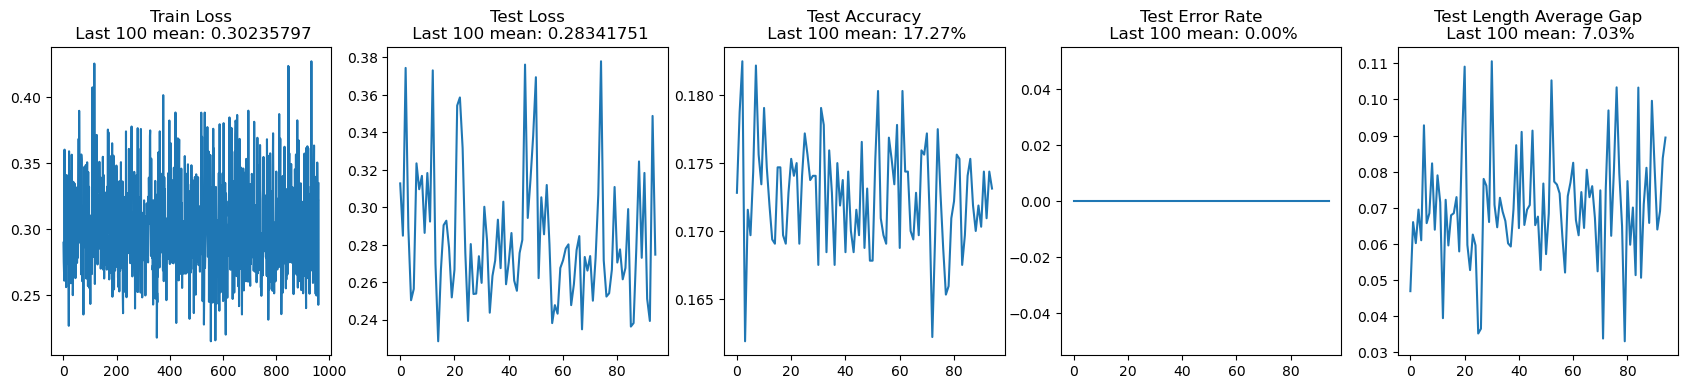

In [ ]:

# plot the logger curves
from cgi import test


plt.figure(figsize=(25, 4))
plt.subplot(1,6,1)
plt.plot(logger_train_loss)
train_loss_last_100 = np.mean(logger_train_loss[-100:])
plt.title('Train Loss\n Last 100 mean: {:.8f}'.format(train_loss_last_100))
plt.subplot(1,6,2)
plt.plot(logger_test_loss)
test_loss_last_100 = np.mean(logger_test_loss[-100:])
plt.title('Test Loss\n Last 100 mean: {:.8f}'.format(test_loss_last_100))
plt.subplot(1,6,3)
plt.plot(logger_test_acc)
test_acc_last_100 = np.mean(logger_test_acc[-100:])
plt.title('Test Accuracy\n Last 100 mean: {:.2%}'.format(test_acc_last_100))
plt.subplot(1,6,4)
plt.plot(logger_test_error_rate)
test_error_rate_last_100 = np.mean(logger_test_error_rate[-100:])
plt.title('Test Error Rate\n Last 100 mean: {:.2%}'.format(test_error_rate_last_100))
plt.subplot(1,6,5)
plt.plot(logger_test_length_gap_avg)
test_length_gap_avg_last_100 = np.mean(logger_test_length_gap_avg[-100:])
plt.title('Test Length Average Gap\n Last 100 mean: {:.2%}'.format(test_length_gap_avg_last_100))

plt.subplot(1,6,6)
plt.plot(logger_test_psudso_false_rate)
test_psudso_false_rate_last_100 = np.mean(logger_test_psudso_false_rate[-100:])
plt.title('Test Pseudo Fake Rate\n Last 100 mean: {:.2%}'.format(test_psudso_false_rate_last_100))
plt.show()


## 4. Generate the trajectory from the model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

test_num = 5
total_trajectories = 3
test_trajectory, test_weighted_adj, test_condition, special_mask = loader.get_test_batch(test_num, total_trajectories)
    
model=model.eval()
logits = model.test(test_condition.to(device), test_weighted_adj.to(device))
predic_trajectory = logits.cpu().numpy()
test_trajectory = test_trajectory.cpu().numpy()
test_weighted_adj = test_weighted_adj.cpu().numpy()
# test_trajectory: [test_num, car_num, block_size]
# predic_trajectories: [test_num, car_num, block_size]
# test_weighted_adj: [test_num, grid_size*grid_size, grid_size*grid_size]

def print_trajectory(predict_trajectory, test_trajectory):
    for i in range(len(predict_trajectory)):
        result_txt = f"weighted graph {i+1:<3}, "
        for j in range(len(predict_trajectory[i])):
            result_txt_predict = result_txt+f"pred {j+1:<3}: {predict_trajectory[i][j]}"
            print(result_txt_predict)
            
            result_txt_test = result_txt+f"true {j+1:<3}: {test_trajectory[i][j]}"
            print(result_txt_test)
        

# remove the special token, input one traj as numpy, return a list without special token
def remove_special_token(trajectory):
    new_trajectory = []
    for i in range(len(trajectory)):
        if trajectory[i] == 0:
            break
        new_trajectory.append(trajectory[i]-1) # 0-indexing
    return new_trajectory


# transfer node, wrighted_adj to graph
def transfer_graph(weighted_adj, grid_size):
    G = nx.DiGraph()
    for i in range(grid_size*grid_size):
        G.add_node(i)
    for i in range(grid_size*grid_size):
        for j in range(grid_size*grid_size):
            if weighted_adj[i,j] != 0:
                G.add_edge(i,j,weight=weighted_adj[i,j])
    return G


# transfer grid into position
def transfer_position(grid_size):
    pos = {}
    for i in range(grid_size):
        for j in range(grid_size):
            pos[i*grid_size+j] = (i,j)
    return pos

# Function to calculate the bounds of the graph
def calculate_bounds(G, pos):
    x_values = [pos[node][0] for node in G]
    y_values = [pos[node][1] for node in G]
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    x_min, x_max = x_min - 0.1 * abs(x_max - x_min), x_max + 0.1 * abs(x_max - x_min) 
    y_min, y_max = y_min - 0.1 * abs(y_max - y_min), y_max + 0.1 * abs(y_max - y_min) 

    return x_min, x_max, y_min, y_max


# Calculate the length of a trajectory
def calculate_length(trajectory, weighted_adj):
    length = 0
    for i in range(len(trajectory)-1):
        length += weighted_adj[trajectory[i],trajectory[i+1]]
    return length


# Plot the trajectories on the graph
def plot_trajs(ax, G, pos, weighted_adj, traj, traj_ = None, ground_truth=False):

    if ax is None:
        nx.draw_networkx_nodes(G, pos, node_size=100, node_color='gray')
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
    else:
        nx.draw_networkx_nodes(G, pos, node_size=100, node_color='gray',ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray', ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{weighted_adj[i, j]:.2f}' for i, j in G.edges()}, label_pos=0.7, ax=ax)
        

    # Plot trajectories
    x = [pos[node][0]+np.random.normal(0,0.01) for node in traj]
    y = [pos[node][1]+np.random.normal(0,0.01) for node in traj]
    traj_len = calculate_length(traj, weighted_adj)
    ax.plot(x, y, marker='o', linewidth = 2.0, alpha=0.5, markersize=10, label=f'Generated Trajectory {traj_len}', color='blue')
    ax.plot(x[0], y[0], marker='*', markersize=20, color='black')

    if traj_ is not None:
        x = [pos[node][0]+np.random.normal(0,0.01) for node in traj_]
        y = [pos[node][1]+np.random.normal(0,0.01) for node in traj_]
        traj_len = calculate_length(traj_, weighted_adj)
        ax.plot(x, y, marker='o',  linewidth = 2.0, alpha=0.5, markersize=10, label=f'Ground Truth Trajectory {traj_len}', color='red')

    ax.legend()


# Plot the training and validation losses
def plot_losses(train_losses, val_losses, eval_interval):
    x = range(0, len(train_losses)*eval_interval, eval_interval)
    plt.plot(x, train_losses, label='train')
    plt.plot(x, val_losses, label='val')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [ ]:
# print the trajectory

print(test_trajectory.shape)
print_trajectory(predic_trajectory, test_trajectory)

(5, 3, 25)
weighted graph 1  , pred 1  : [23 18 19 14  9 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 1  , true 1  : [23 18 13  8  9 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 1  , pred 2  : [ 4  5 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 1  , true 2  : [ 4  9 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 1  , pred 3  : [23 18 13  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 1  , true 3  : [23 18 13  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 2  , pred 1  : [9 4 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
weighted graph 2  , true 1  : [9 4 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
weighted graph 2  , pred 2  : [ 6 11 16 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
weighted graph 2  , true 2  : [ 6 11 16 21  0  0  0  0  0  0  0  0  0

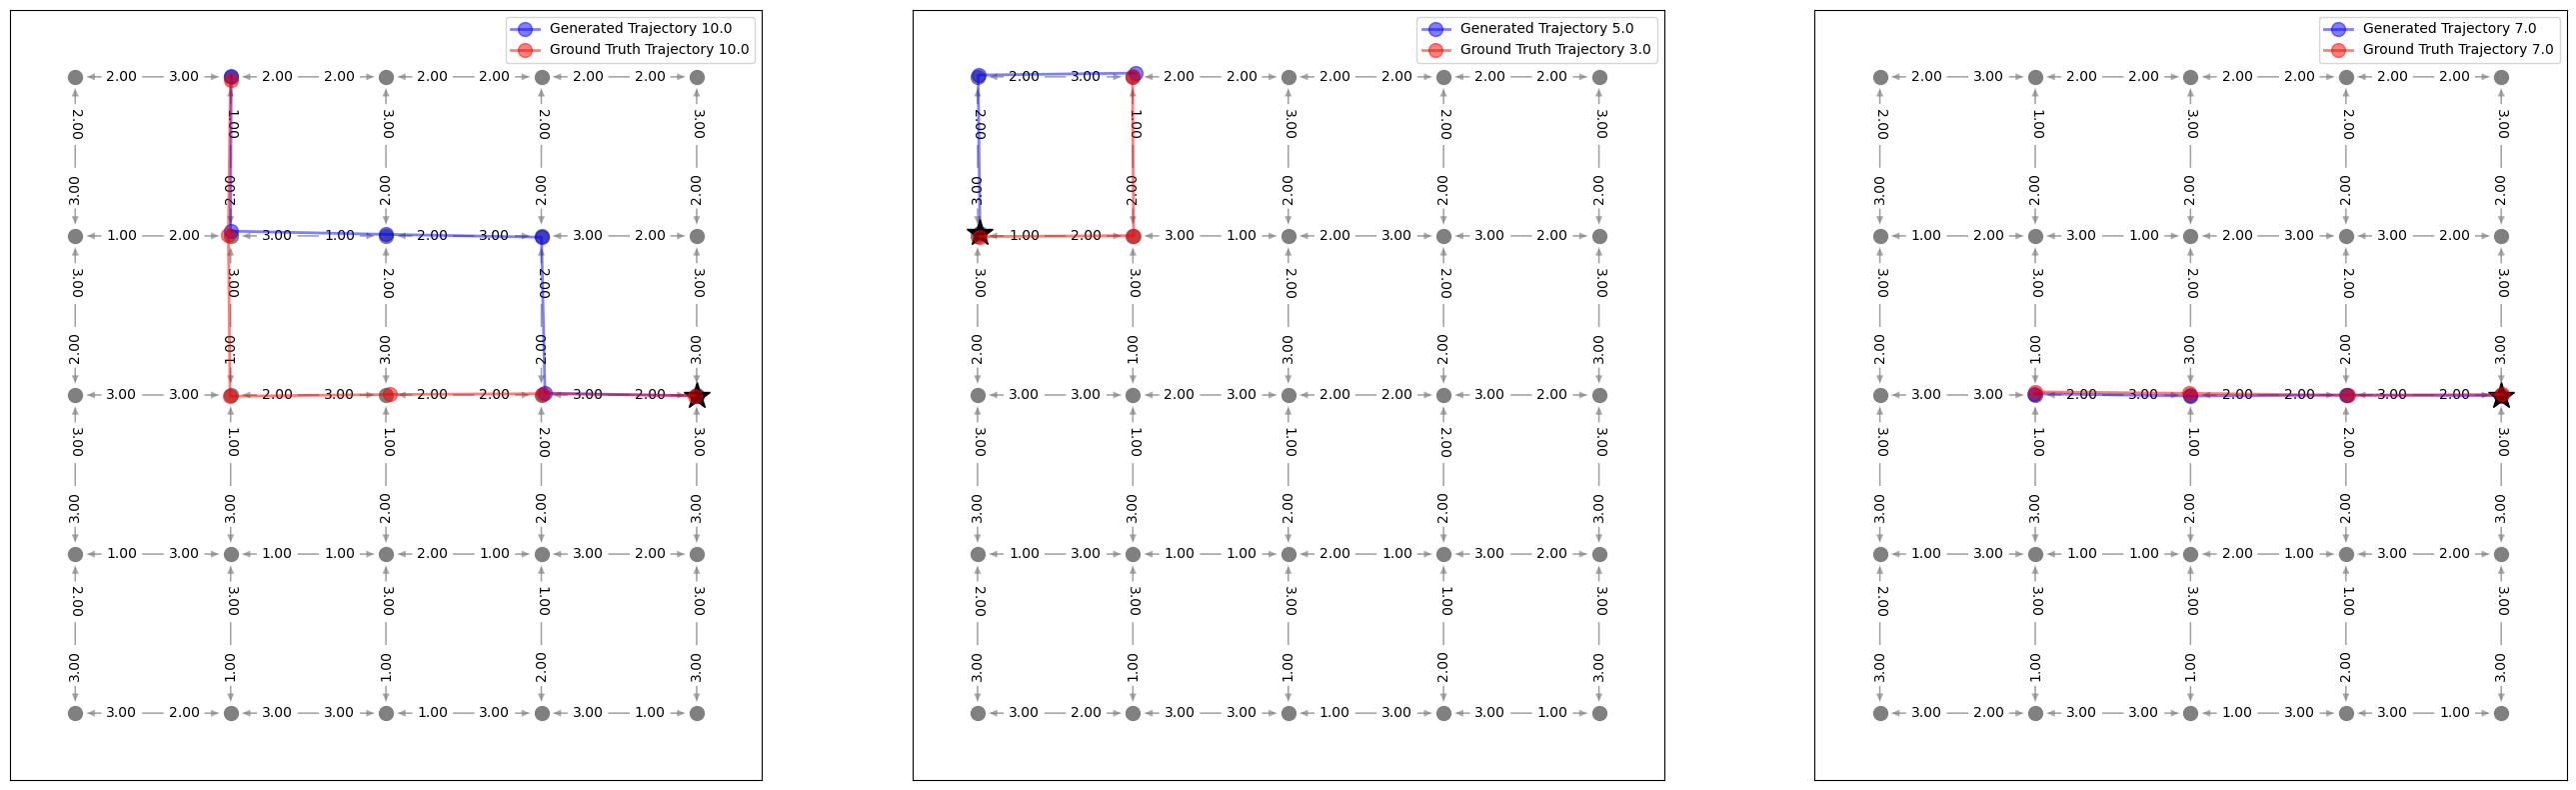

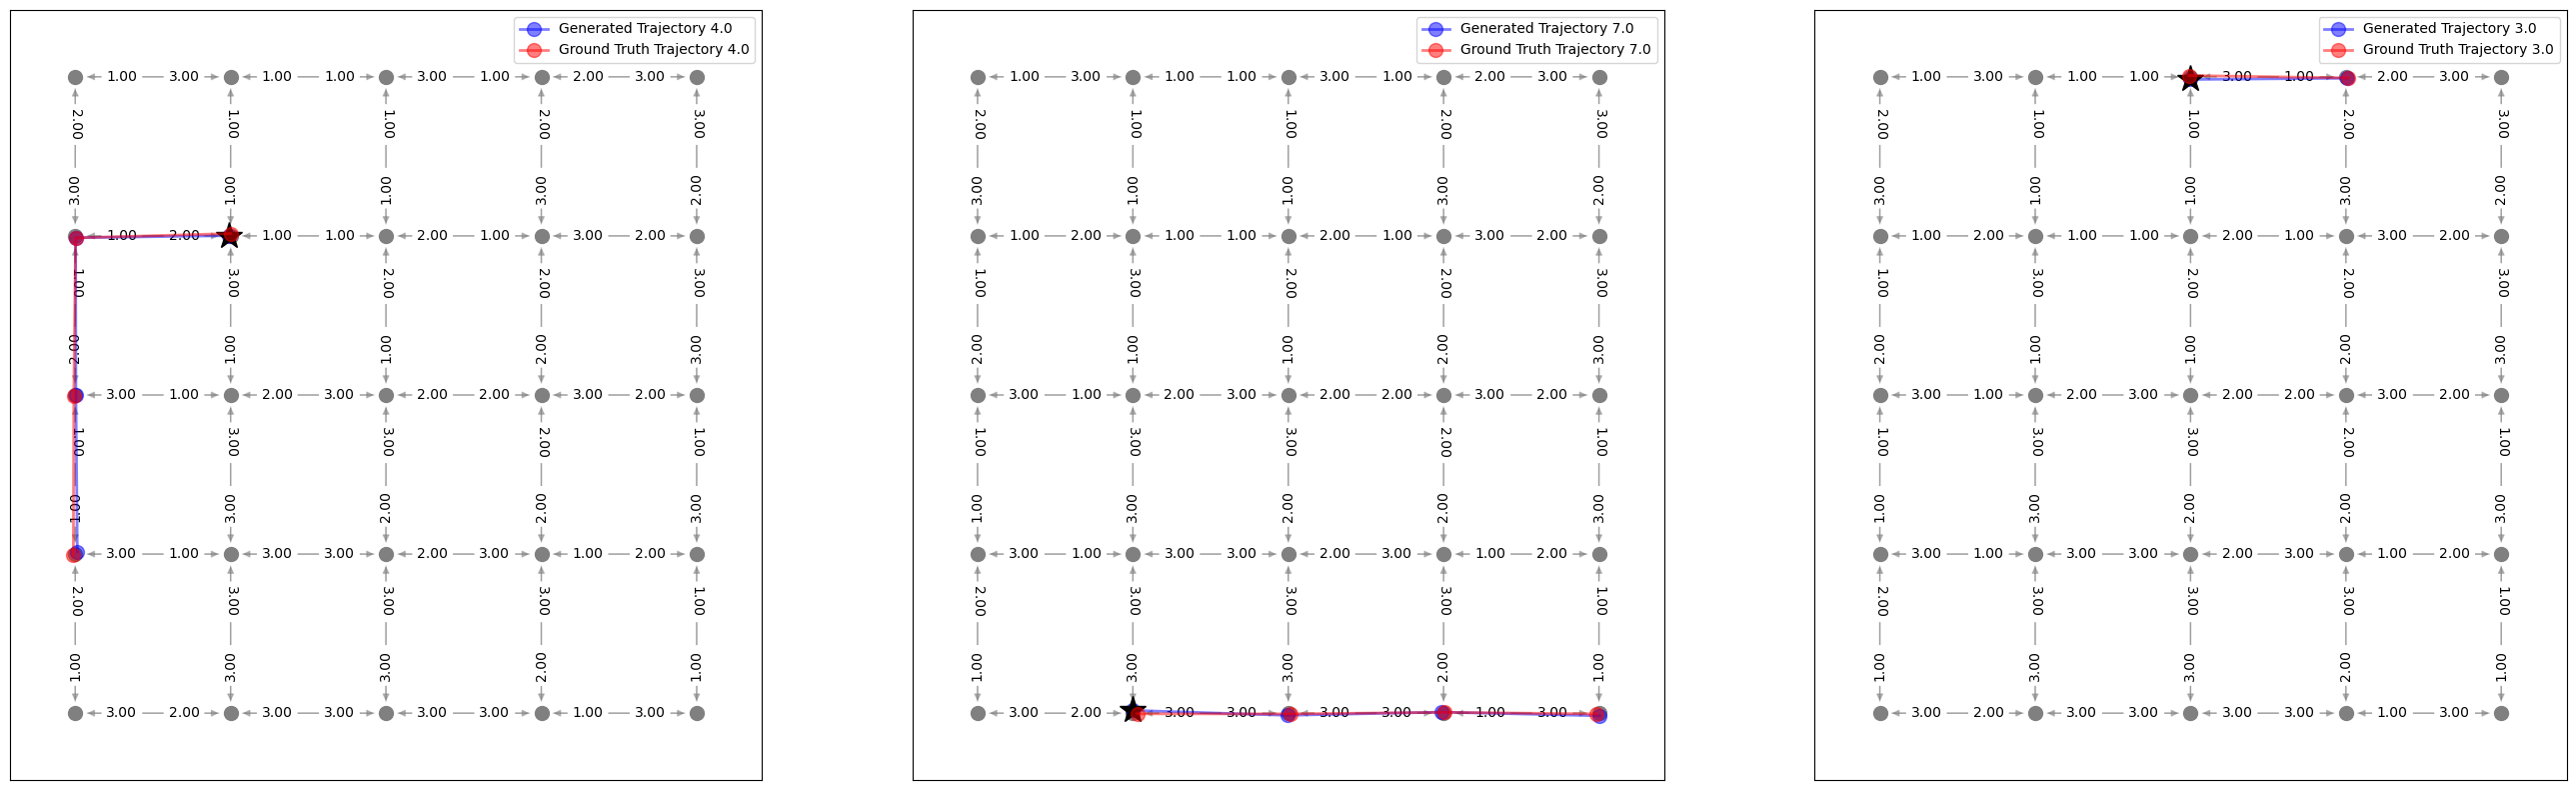

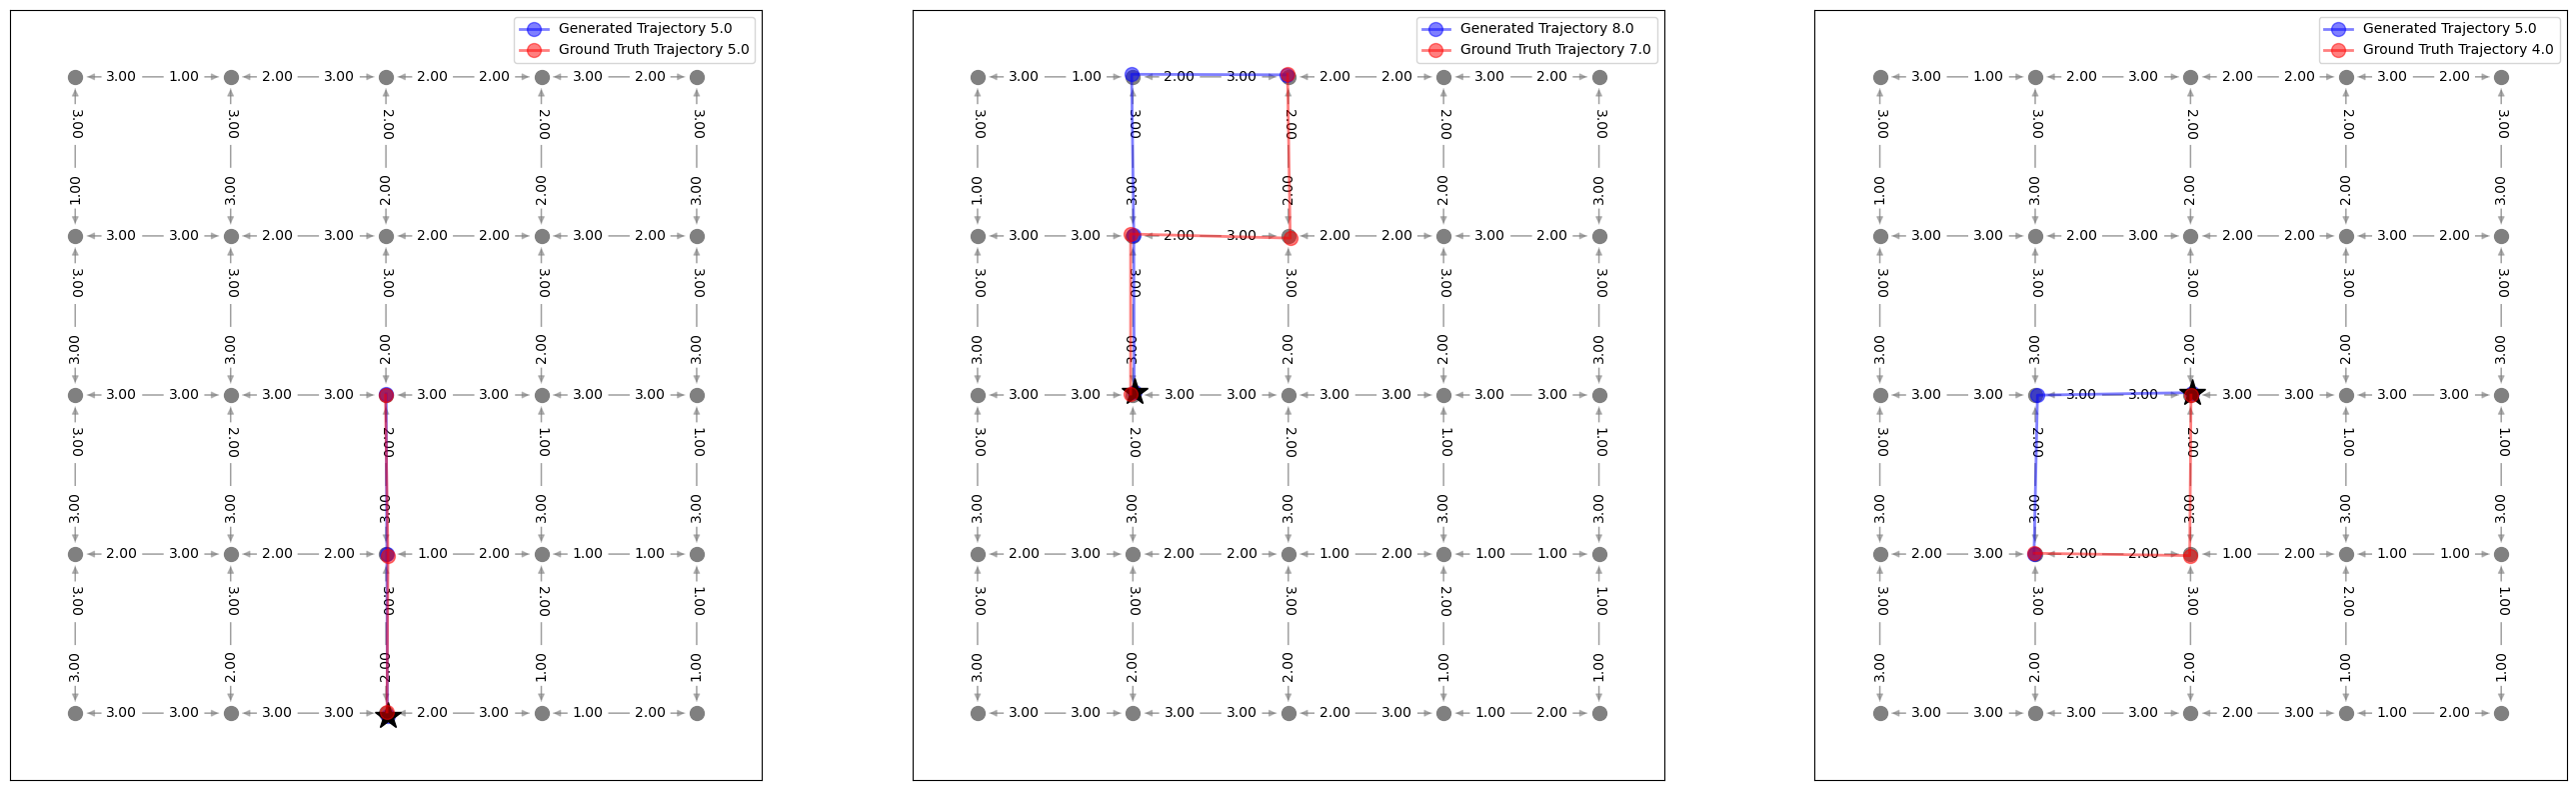

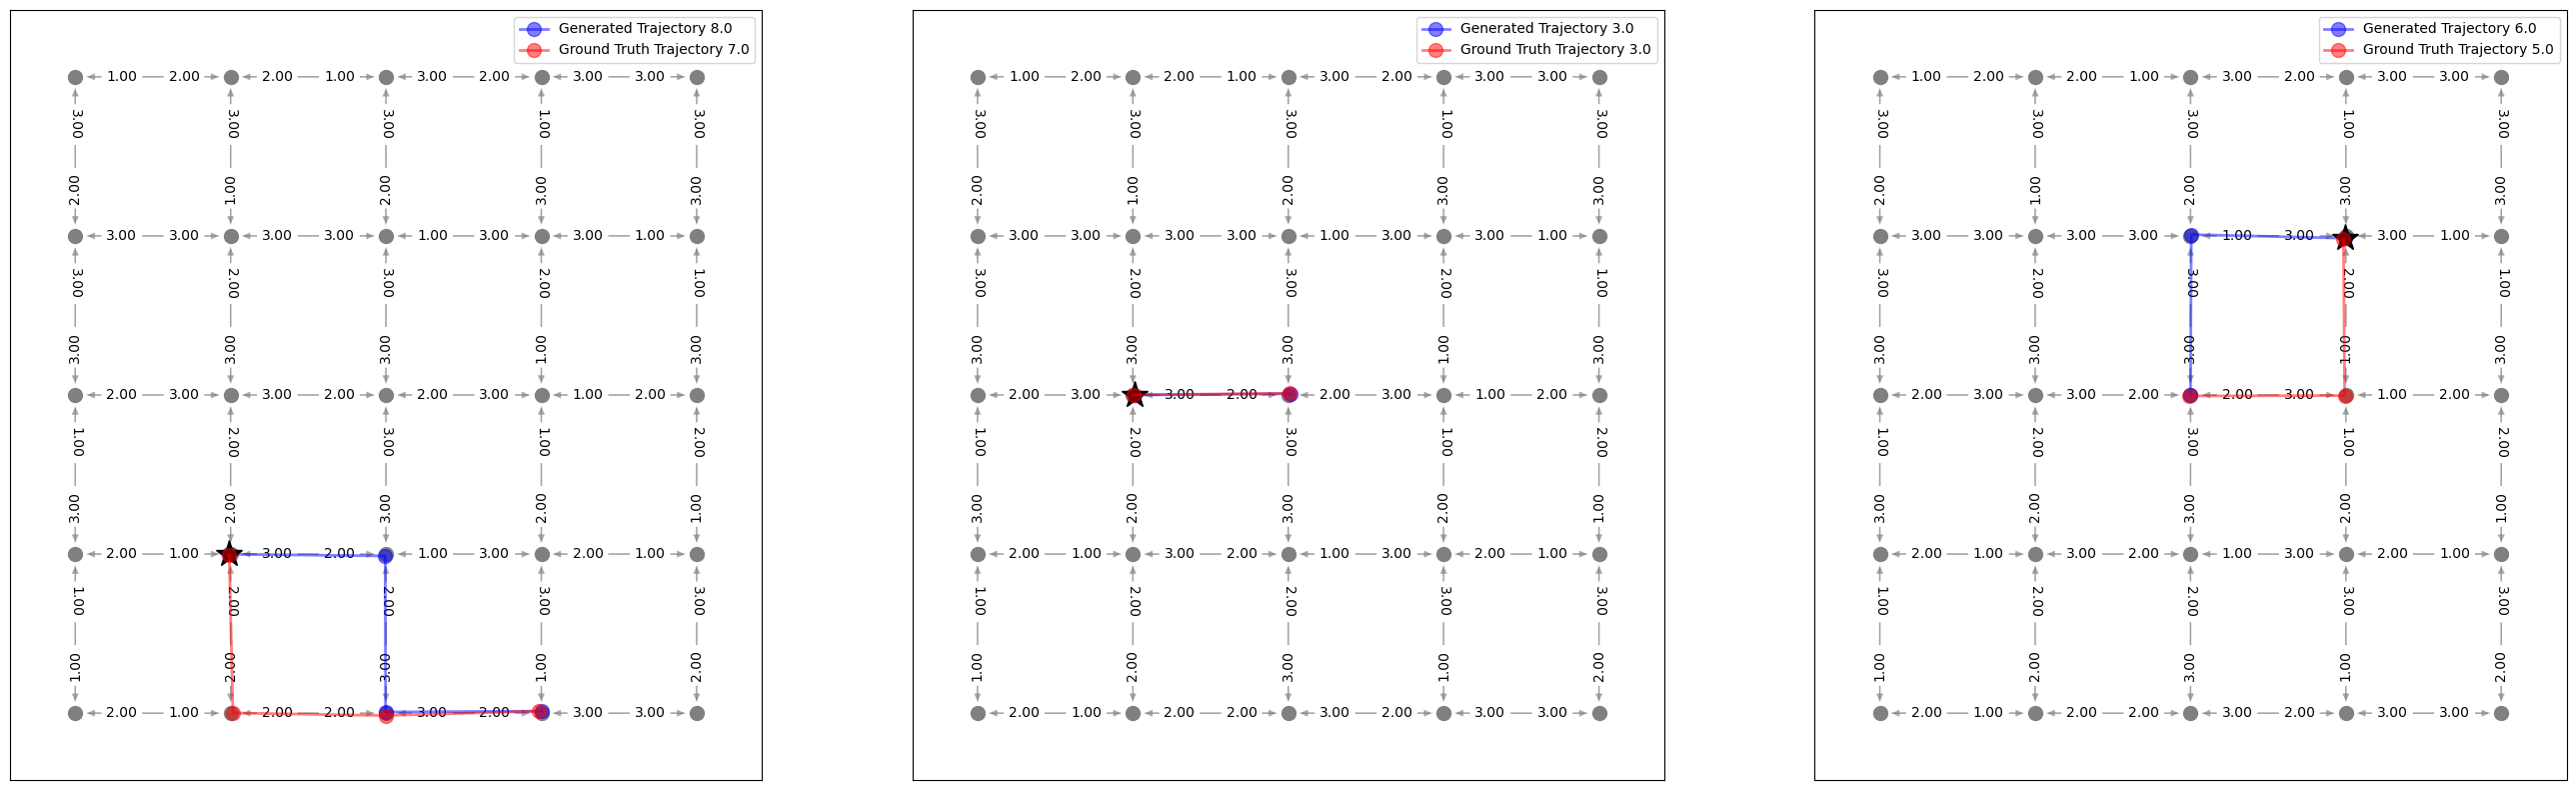

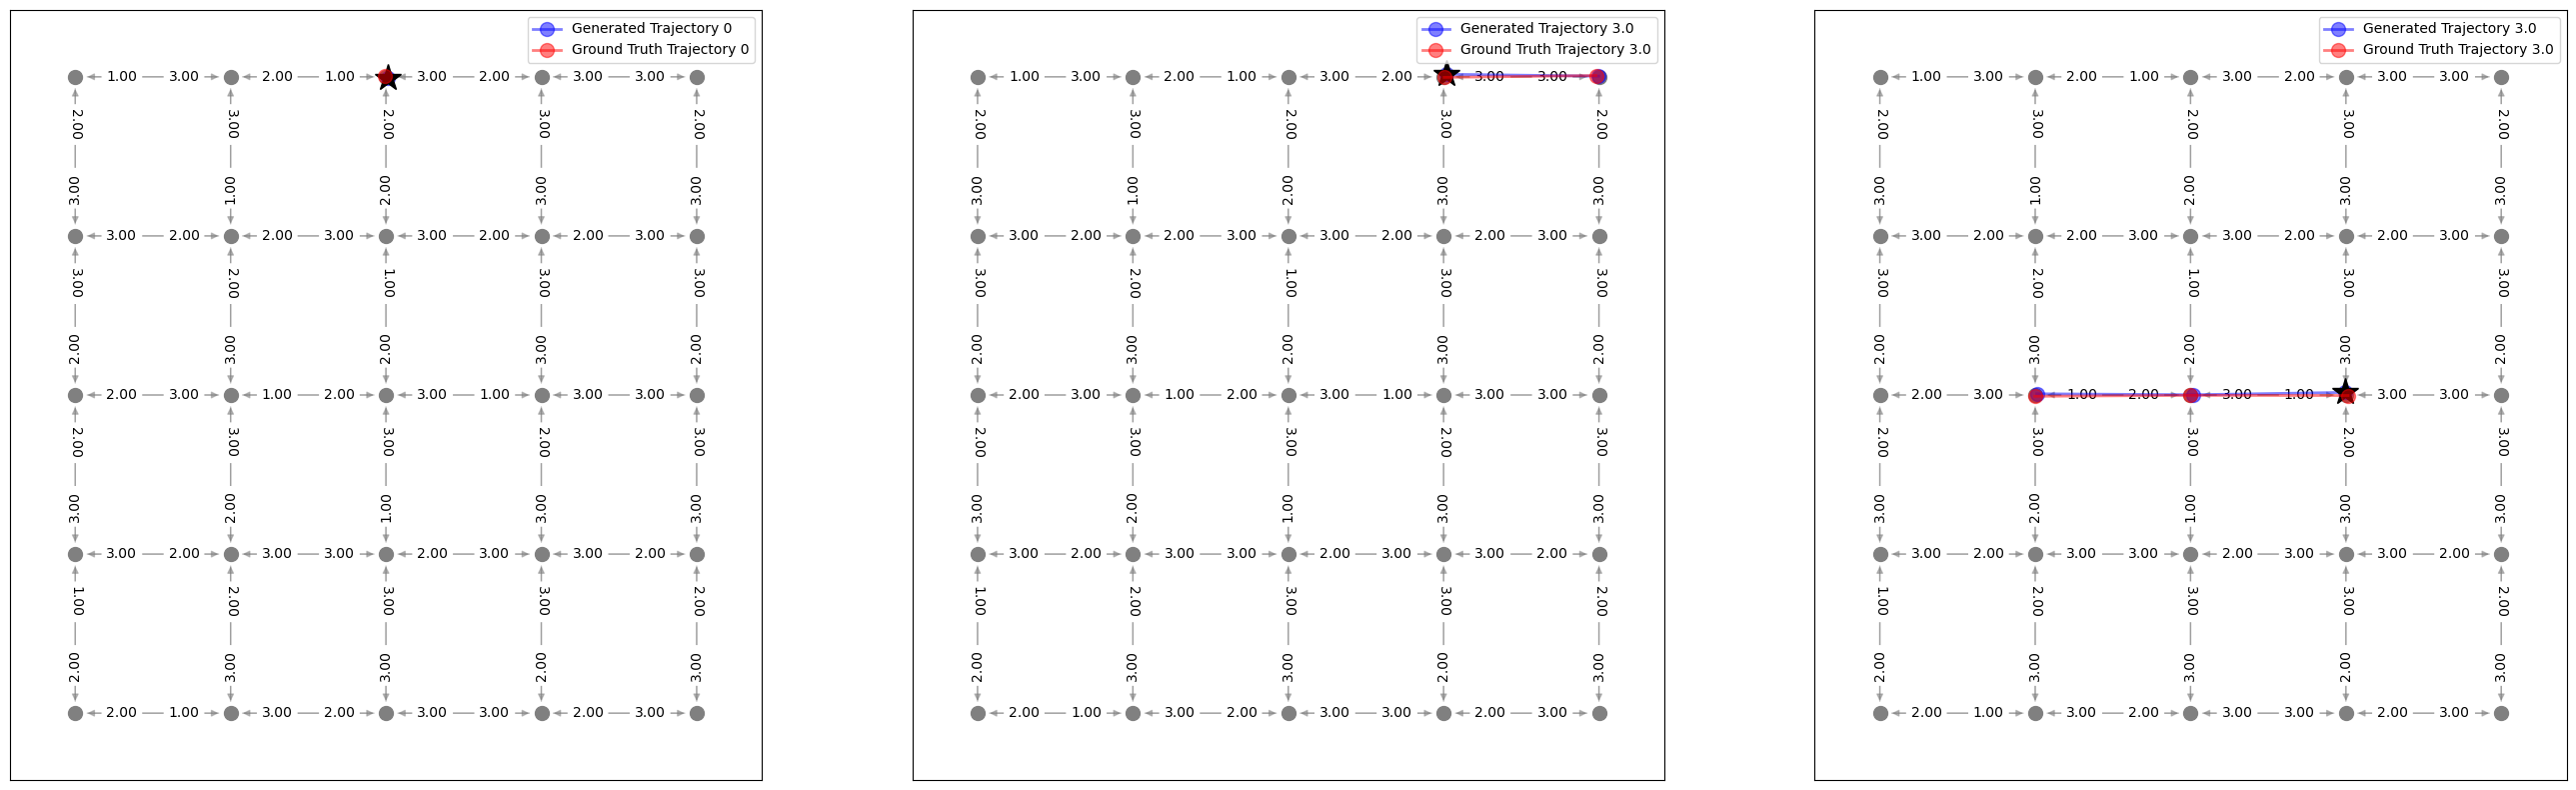

In [ ]:
# plot the trajectory

fig_size = 10

for i in range(test_num):
    fig, ax = plt.subplots(1, total_trajectories, figsize=((fig_size+1)*total_trajectories, fig_size))
    for j in range(total_trajectories):
        traj = predic_trajectory[i,j] # (block_size,)
        traj_ = test_trajectory[i,j] # (block_size,)
        traj = remove_special_token(traj)
        traj_ = remove_special_token(traj_)

        G = transfer_graph(test_weighted_adj[i], grid_size)
        pos = transfer_position(grid_size)

        plot_trajs(ax[j], G, pos, test_weighted_adj[i], traj, traj_, ground_truth=False)
    plt.show()
